In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gtsa

In [3]:
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import rasterio
import psutil

# Objective
- Everything should be lazy and parallelized with dask

#### Caution
- If changing code related dask in gtsa library, restart the notebook for changes to take effect, despite the autoreload command above. Lazily loaded states are not reset by the magic command.
- If running code from a python script instead of notebook, start cluster under "\__main__\" e.g. https://github.com/adehecq/ragmac_xdem/blob/master/scripts/main_experiment1.py#L75

In [4]:
workers = psutil.cpu_count(logical=True)-1
client = gtsa.io.dask_start_cluster(workers,
                                    port=':8787')


Dask dashboard at: http://127.0.0.1:8787/status
Workers: 31
Threads per worker: 1 



## Inputs
- Data in the example are stored on AWS S3 in EPSG 4326. 
- The crs metadata is not saved to the zarr files (issue under investigation) so we need to assign it after lazily loading the data.

In [5]:
zarr_url = 'http://petrichor.s3.us-west-2.amazonaws.com/rainier/stack/stack.zarr'
crs = rasterio.crs.CRS.from_epsg(4326)

## Load data
- Rechunk with dask to optimize processing, depending on the data object
- If the total object size is small, use smaller chunks and vice versa

In [6]:
ds = xr.open_dataset(zarr_url,chunks='auto',engine='zarr')
tc,yc,xc = gtsa.io.determine_optimal_chuck_size(ds,print_info = True)
ds = xr.open_dataset(zarr_url,chunks={'time': tc, 'y': yc, 'x':xc},engine='zarr')
ds = ds.rio.write_crs(crs)


Determining optimal chunk size for processing
Chunk shape: (21,120,200)
Chunk size: 2016000 (2.016G)


In [7]:
ds['band1']

<xarray.DataArray 'band1' (time: 21, y: 13133, x: 21786)>
dask.array<open_dataset-5b22096837235a8d20afb30a3df78725band1, shape=(21, 13133, 21786), dtype=float32, chunksize=(21, 120, 200), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1951-08-16 1955-09-15 ... 2008-10-01
  * x            (x) float64 -121.9 -121.9 -121.9 ... -121.4 -121.4 -121.4
  * y            (y) float64 47.01 47.01 47.01 47.01 ... 46.7 46.7 46.7 46.7
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

## Subset
- Subset stack by the bounds of a glacier, found within the bounds of the DEM stack
- We will choose Nisqually Glacier

In [8]:
rgi02_file = '/mnt/storage/knuth/sites/strato_glaciers/data/rgi/02_rgi60_WesternCanadaUS.geojson'
rgi02_gdf = gpd.read_file(rgi02_file)

In [9]:
xmin, ymin, xmax, ymax = ds['band1'].rio.bounds() # get bounds of stack
bounds_gdf = gtsa.geospatial.bounds2polygon(xmin, xmax, ymin, ymax)

In [10]:
glaciers_gdf = gpd.sjoin(rgi02_gdf, bounds_gdf, predicate='intersects') # intersecting glaciers
glaciers_gdf = glaciers_gdf[glaciers_gdf['Name'].str.len() > 2] # named
glaciers_gdf = glaciers_gdf[glaciers_gdf['Area']>1] # greater than 1 km^2

In [11]:
glaciers_gdf['Name'].values

array(['Carbon Glacier WA', 'Winthrop Glacier WA', 'Russell Glacier WA',
       'North Mowich Glacier WA', 'Emmons Glacier WA',
       'Liberty Gap Glacier WA', 'Edmunds Glacier WA',
       'South Mowich Glacier WA', 'Fryingpan Glacier WA',
       'Tahoma Glacier WA', 'Puyallup Glacier WA', 'Ingraham Glacier WA',
       'Whitman Glacier WA', 'Nisqually Glacier WA', 'Kautz Glacier WA',
       'Ohanapecosh Glacier WA', 'South Tahoma Glacier WA',
       'Cowlitz Glacier WA', 'Wilson Glacier WA'], dtype=object)

In [12]:
glaciers = ['Nisqually Glacier WA', ]
glacier_gdf = glaciers_gdf[glaciers_gdf['Name'].str.contains(glaciers[0])]

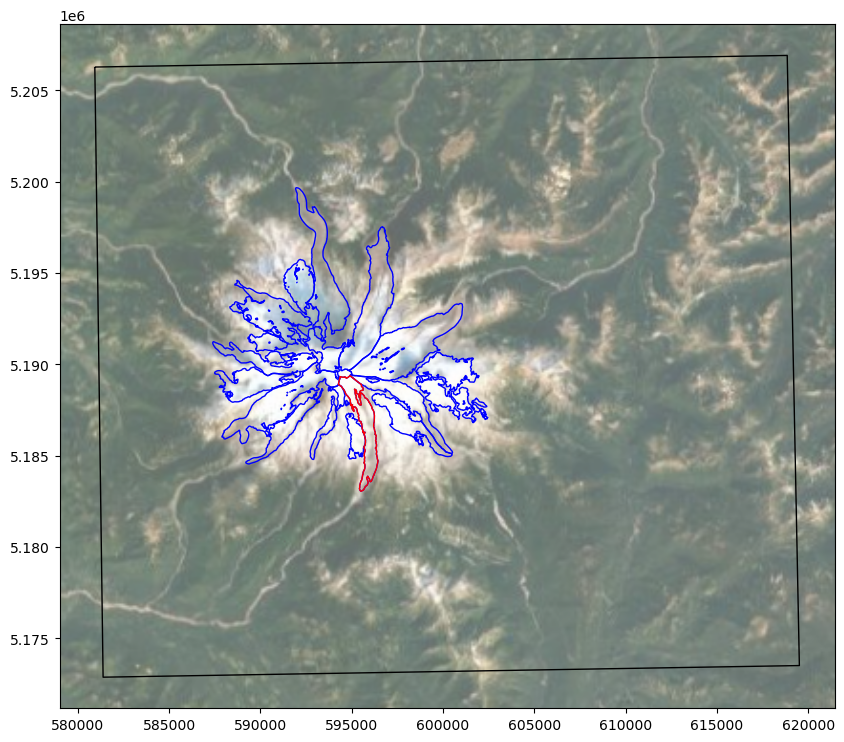

In [13]:
fig,ax = plt.subplots(1,figsize=(10,10))
bounds_gdf.to_crs(ds.rio.estimate_utm_crs()).plot(ax = ax, facecolor = 'none', edgecolor='k')
glaciers_gdf.to_crs(ds.rio.estimate_utm_crs()).plot(ax=ax, facecolor = 'none', edgecolor='b')
glacier_gdf.to_crs(ds.rio.estimate_utm_crs()).plot(ax=ax, facecolor = 'none', edgecolor='r')
ctx.add_basemap(ax, 
                source="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
                crs= ds.rio.estimate_utm_crs(),
                alpha = 0.6,
                zoom=10)

In [14]:
#optional small window for testing
xmin, xmax = -121.79, -121.78
ymin, ymax = 46.89, 46.90

# xmin, ymin, xmax, ymax = glacier_gdf.bounds.values[0]
subset = ds.sel(x=slice(xmin, xmax), y=slice(ymax,ymin))

## Plot a DEM

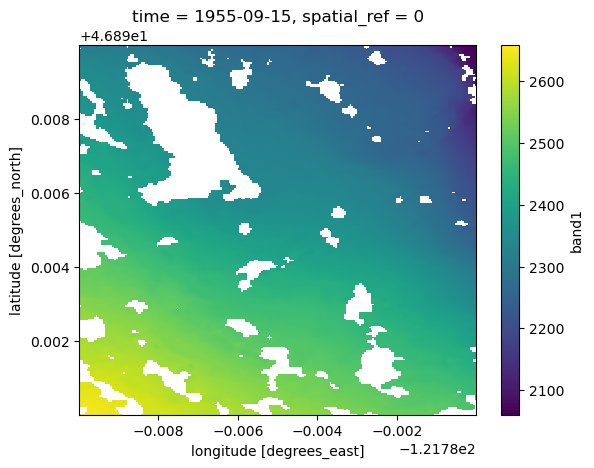

In [15]:
subset['band1'].isel(time=1).plot();

## Compute per pixel DEM count

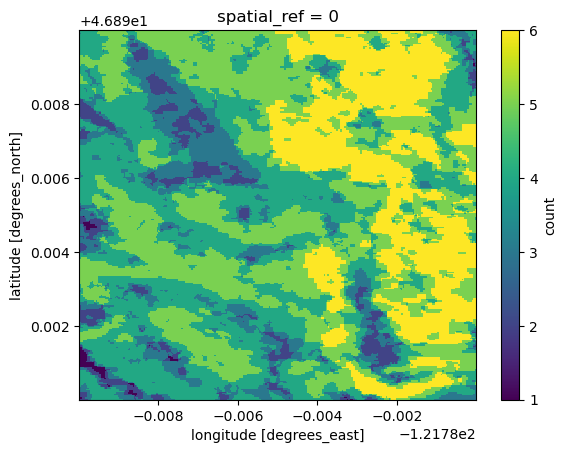

In [16]:
count_da = gtsa.temporal.xr_dask_count(subset)
count_da.plot();

## Compute per pixel DEM nmad

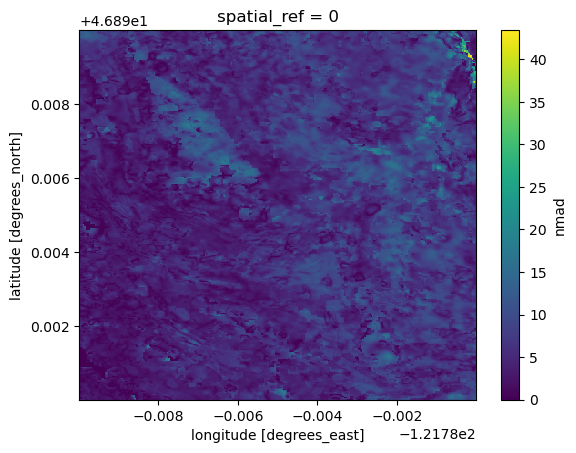

In [17]:
nmad_da = gtsa.temporal.xr_dask_nmad(subset)
nmad_da.plot();

## Linear regression

In [18]:
time_stamps = [gtsa.utils.date_time_to_decyear(i) for i in [pd.to_datetime(j) for j in subset['band1'].time.values]]
time_stamps = np.array(time_stamps)

results = gtsa.temporal.dask_apply_linreg(subset['band1'],
                                          'time', 
                                          kwargs={'times':time_stamps,
                                                  'count_thresh':3})
results = xr.Dataset({'slope':results[0],
                      'intercept':results[1]}).compute()

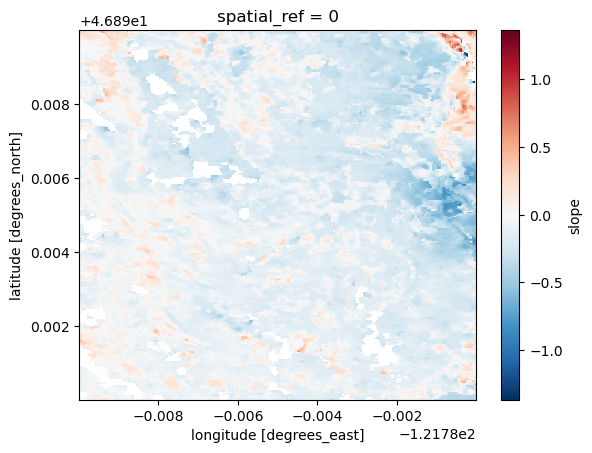

In [19]:
results['slope'].plot()

## Gaussian Process regression

In [20]:
kernel = gtsa.temporal.GPR_glacier_kernel()

In [21]:
time_stamps = [gtsa.utils.date_time_to_decyear(i) for i in [pd.to_datetime(j) for j in subset['band1'].time.values]]
time_stamps = np.array(time_stamps)

In [22]:
prediction_time_series = gtsa.temporal.create_prediction_timeseries(start_date = '1950-01-01',
                                               end_date = '2020-01-01',
                                               dt ='M')

In [23]:
ds_result = gtsa.temporal.dask_apply_GPR(subset['band1'],
                                       'time', 
                                       kwargs={'times':time_stamps,
                                               'kernel': kernel,
                                               'prediction_time_series' : prediction_time_series})

In [24]:
ds_result['mean_prediction']

<xarray.DataArray 'mean_prediction' (time: 840, y: 436, x: 436)>
dask.array<rechunk-merge, shape=(840, 436, 436), dtype=float64, chunksize=(752, 109, 146), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -121.8 -121.8 -121.8 ... -121.8 -121.8 -121.8
  * y            (y) float64 46.9 46.9 46.9 46.9 ... 46.89 46.89 46.89 46.89
    spatial_ref  int64 0
  * time         (time) float64 1.95e+03 1.95e+03 1.95e+03 ... 2.02e+03 2.02e+03

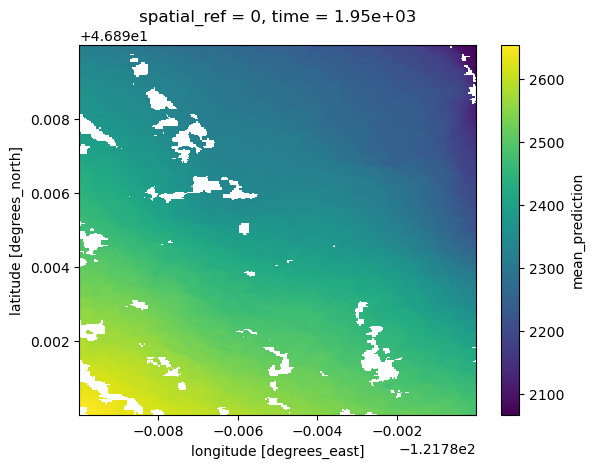

In [25]:
ds_result['mean_prediction'].isel(time=1).plot();

In [26]:
! rm -rf test.zarr

In [27]:
ds_result.to_zarr('test.zarr')

In [28]:
r = xr.open_dataset('test.zarr', engine = 'zarr')

In [29]:
r

<xarray.Dataset>
Dimensions:          (time: 840, y: 436, x: 436)
Coordinates:
    spatial_ref      int64 ...
  * time             (time) float64 1.95e+03 1.95e+03 ... 2.02e+03 2.02e+03
  * x                (x) float64 -121.8 -121.8 -121.8 ... -121.8 -121.8 -121.8
  * y                (y) float64 46.9 46.9 46.9 46.9 ... 46.89 46.89 46.89 46.89
Data variables:
    mean_prediction  (time, y, x) float64 ...
    std_prediction   (time, y, x) float64 ...

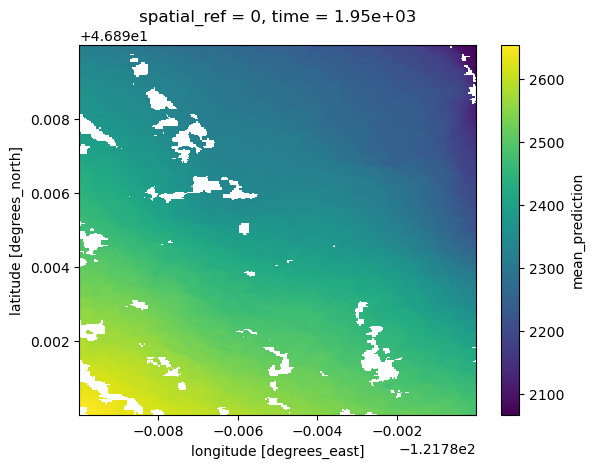

In [30]:
r['mean_prediction'].isel(time=1).plot()

## GP on single array
- use this to test different kernels

In [31]:
arr = subset['band1'].isel(x=1, y = 1).values

In [32]:
mean_prediction, std_prediction = gtsa.temporal.dask_GPR(arr,
                                                         times = time_stamps,
                                                         kernel = kernel,
                                                         prediction_time_series = prediction_time_series)

In [33]:
GPR_df = pd.DataFrame([mean_prediction,]).T
GPR_df.index = prediction_time_series

GPR_std_df = pd.DataFrame([std_prediction,]).T
GPR_std_df.index = prediction_time_series

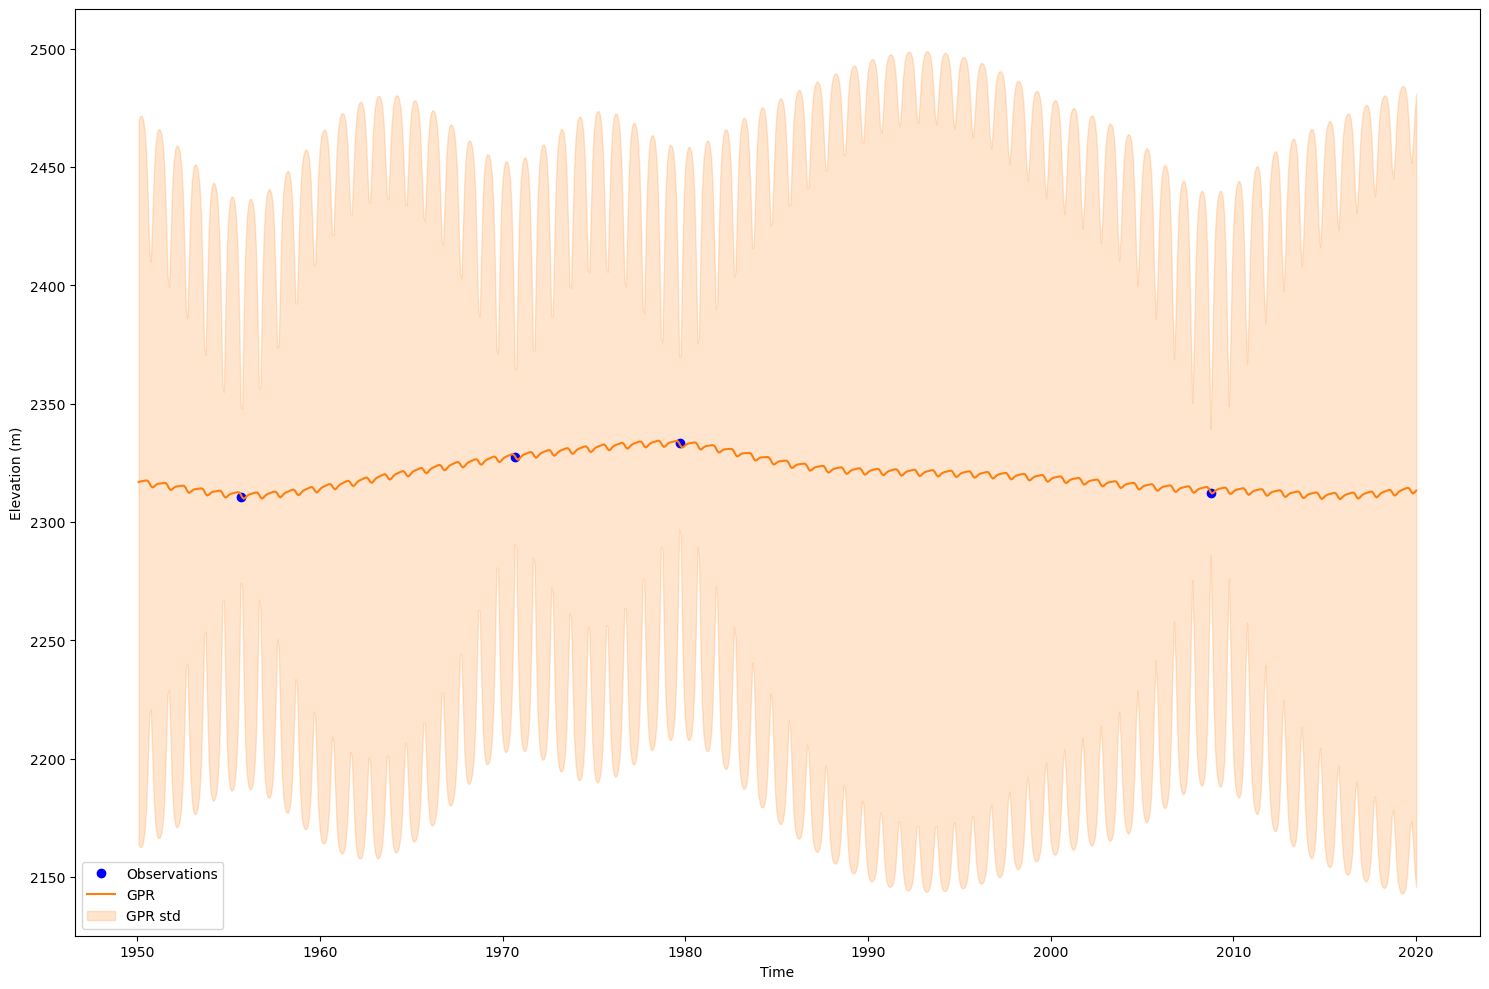

In [34]:
gtsa.plotting.plot_time_series_gallery(np.array([time_stamps,]),
                                       np.array([arr,]),
                                       predictions_df_list=[GPR_df],
                                       std_df_list=[GPR_std_df],
                                       legend_labels = ["Observations",
                                                           "GPR",
                                                           "GPR std"])